Thanks to 
- https://github.com/heartcored98/Standalone-DeepLearning-Chemistry/blob/master/Lec05/Lec05_lipo_graph_gcn_prediction.ipynb
- https://untitledtblog.tistory.com/152
    

In [28]:
import pandas as pd
import numpy as np
from rdkit import Chem

## 1. Load data

### 1.1 prepare data

In [287]:
from sklearn.model_selection import train_test_split

def get_split_data(train_ratio=0.8, valid_ratio=0.1, test_ratio=0.1,
                   seed=2020):

    # load dataset
    df = pd.read_csv('../sample_data/Lipophilicity.csv')

    train_val, test = train_test_split(df,
                                       test_size=test_ratio,
                                       random_state=seed)
    
    train, val = train_test_split(train_val,
                                  test_size=valid_ratio/(train_ratio+valid_ratio),
                                  random_state=seed)
    return train, val, test

In [291]:
df = pd.read_csv('../sample_data/Lipophilicity.csv')
df_tot = get_split_data()
df_train = df_tot[0]

In [292]:
df_train.head()

,CMPD_CHEMBLID,exp,smiles
1809,CHEMBL217620,4.20,CC(C)N(C(C)C)C(=O)C(C(CNC(=O)NCc1ccccc1F)c2ccc...
397,CHEMBL1738761,0.76,NCC[C@@H](Oc1cc(Cl)ccc1C#N)c2ccccc2
3236,CHEMBL249295,3.20,CN1CCN(CC1)[C@@H]2C[C@@H](C2)c3nc(c4ccc5ccc(nc...
2330,CHEMBL1319232,2.10,Cc1ccc(cc1)N2NC(=O)c3cccnc23
152,CHEMBL1481866,1.70,NC(=O)c1ccc(Oc2cccc3cccnc23)c(c1)[N+](=O)[O-]


### 1.2 construct Mol2Graph

In [293]:
def get_unique_atom_symbols(smi):
    mol = Chem.MolFromSmiles(smi)
    symbols = set([atom.GetSymbol() for atom in mol.GetAtoms()])
    return symbols

def get_num_atom(smi):
    mol = Chem.MolFromSmiles(smi)
    num_atom = len([atom.GetSymbol() for atom in mol.GetAtoms()])
    return num_atom

In [294]:
# extract the whole symbol set (and apply unique)
# extract the whole num of atoms (and apply max)

LIST_SYMBOLS = list(set.union(*df['smiles'].apply(lambda x: get_unique_atom_symbols(x)).values))
MAX_LEN = max(df['smiles'].apply(lambda x: get_num_atom(x)))

In [295]:
LIST_SYMBOLS, MAX_LEN, len(LIST_SYMBOLS)

(['B', 'N', 'I', 'Cl', 'F', 'P', 'S', 'O', 'C', 'Si', 'Se', 'Br'], 115, 12)

In [296]:
def atom_feature(atom):
    # 1) atom symbol
    # 2) degree
    # 3) 붙어 있는 수소 원자의 수
    # 4) Valence (원자가는 어떤 원자가 다른 원자들과 어느 정도 수준으로 공유 결합을 이루는가를 나타내는 척도)
    # 5) Aromatic 여부 (평평한 고리 구조를 가진 방향족인지)
    return np.array(char_to_ix(atom.GetSymbol(), LIST_SYMBOLS) +
                    char_to_ix(atom.GetDegree(), [0, 1, 2, 3, 4, 5]) +
                    char_to_ix(atom.GetTotalNumHs(), [0, 1, 2, 3, 4]) +
                    char_to_ix(atom.GetImplicitValence(), [0, 1, 2, 3, 4, 5]) +
                    char_to_ix(int(atom.GetIsAromatic()), [0, 1]))    # (40, 6, 5, 6, 2)

def char_to_ix(x, allowable_set):
    if x not in allowable_set:
        return [0] # Unknown Atom Token
    return [allowable_set.index(x)+1]

def mol2graph(smi, MAX_LEN):
    # MAX_LEN 최대 원자 수
    mol = Chem.MolFromSmiles(smi)

    X = np.zeros((MAX_LEN, 5), dtype=np.uint8)
    A = np.zeros((MAX_LEN, MAX_LEN), dtype=np.uint8)

    temp_A = Chem.rdmolops.GetAdjacencyMatrix(mol
                                             ).astype(np.uint8, copy=False)[:MAX_LEN, :MAX_LEN]
    num_atom = temp_A.shape[0]
    eye_matrix = np.eye(temp_A.shape[0], dtype=np.uint8)
    A[:num_atom, :num_atom] = temp_A + eye_matrix
    
    for i, atom in enumerate(mol.GetAtoms()):
        feature = atom_feature(atom)
        X[i, :] = feature
        if i + 1 >= num_atom: break
            
    return X, A

Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14


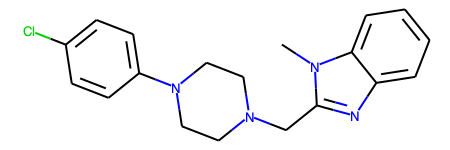

In [297]:
print(temp)
Chem.MolFromSmiles(temp)

### 1.3 Construct Dataset/DataLoader

In [298]:
from torch.utils.data import Dataset, DataLoader

class gcnDataset(Dataset):
    def __init__(self, df, max_len=MAX_LEN):
        self.smiles = df["smiles"]
        self.exp = df["exp"].values
                
        list_X, list_A = [], []
        for i, smiles in enumerate(self.smiles):
            X, A = mol2graph(smiles, max_len)
            list_X.append(X)
            list_A.append(A)
            
        self.X = np.array(list_X, dtype=np.uint8)
        self.A = np.array(list_A, dtype=np.uint8)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.A[index], self.exp[index]

In [299]:
# datasets[0] = train set
sample_dataset = gcnDataset(datasets[0])

In [300]:
print(sample_dataset.A.shape)
print(sample_dataset.X.shape)
print(sample_dataset.exp.shape)

(3359, 115, 115)
(3359, 115, 5)
(3359,)


## 2. Model Construction

In [332]:
import torch
import torch.nn as nn
import torch.optim as optim


class BN1d(nn.Module):
    def __init__(self, out_dim, use_bn):
        super(BN1d, self).__init__()
        self.use_bn = use_bn
        self.bn = nn.BatchNorm1d(out_dim)
             
    def forward(self, x):

        # When skip BN
        if not self.use_bn:
            output = x
            return  output
        
        # When use BN
        output = x.view(-1, x.shape[-1])
        output = self.bn(output)
        output = output.view(x.shape)
        return output
    
    
class GConv(nn.Module):
    def __init__(self, input_dim, output_dim, use_bn):
        super(GConv, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        self.bn = BN1d(output_dim, use_bn)
        self.relu = nn.ReLU()
        
    def forward(self, X, A):
        # invariant node feature을 transformation
        x = self.fc(X) #X'=WX+b (W=(output_dim,input_dim), X=(output_dim,feature_dim))
        x = torch.matmul(A, x) # A*X'
        x = self.relu(self.bn(x)) # relu(A*X')
        return x, A
          
    
class Readout(nn.Module):
    def __init__(self, out_dim, molvec_dim):
        super(Readout, self).__init__()
        self.readout_fc = nn.Linear(out_dim, molvec_dim)
        nn.init.xavier_normal_(self.readout_fc.weight.data)

    def forward(self, output_H):
        molvec = self.readout_fc(output_H)
        molvec = torch.mean(molvec, dim=1)
        return molvec
    

class GCNNet(nn.Module):
    
    def __init__(self, args):
        super(GCNNet, self).__init__()
        
        # Create Atom Element embedding layer
        self.embedding = self.create_emb_layer([args.vocab_size, args.degree_size,
                                                args.numH_size, args.valence_size,
                                                args.isarom_size],  args.emb_train)    
        
        self.gcn_layers = nn.ModuleList()
        for i in range(args.n_layer):
            self.gcn_layers.append(GConv(args.in_dim if i==0 else args.out_dim, args.out_dim, args.use_bn))
                                   
        self.readout = Readout(args.out_dim, args.molvec_dim)
        
        self.fc1 = nn.Linear(args.molvec_dim, args.molvec_dim//2)
        self.fc2 = nn.Linear(args.molvec_dim//2, args.molvec_dim//2)
        self.fc3 = nn.Linear(args.molvec_dim//2, 1)
        self.relu = nn.ReLU()
        
    def create_emb_layer(self, list_vocab_size, emb_train=False):
        '''
            list_vocab_size (embed_size for 5 features)
            - vocab_size = 12 (총 원소개수 12개임)
            - degree_size = 6 (0,1,2,3,4,5)
            - numH_size = 5 (0,1,2,3,4)
            - valence_size = 6 (0,1,2,3,4,5)
            - isarom_size = 2 (y/n)
        '''
        list_emb_layer = nn.ModuleList()
        for i, vocab_size in enumerate(list_vocab_size):
            
            # 
            vocab_size += 1
            
            # nn.Embedding
            ## num_embeddings : 임베딩을 할 단어들의 개수. 다시 말해 단어 집합의 크기입니다.
            ## embedding_dim : 임베딩 할 벡터의 차원입니다. 사용자가 정해주는 하이퍼파라미터입니다.
            emb_layer = nn.Embedding(vocab_size, vocab_size)
            weight_matrix = torch.zeros((vocab_size, vocab_size))
            
            # diagonal matrix
            for i in range(vocab_size):
                weight_matrix[i][i] = 1
                
            emb_layer.load_state_dict({'weight': weight_matrix})
            
            # grad flow 
            emb_layer.weight.requires_grad = emb_train
            
            list_emb_layer.append(emb_layer)
        return list_emb_layer

    def _embed(self, x):
        list_embed = list()
        for i in range(5):
            list_embed.append(self.embedding[i](x[:, :, i]))
        x = torch.cat(list_embed, 2)
        return x
        
    def forward(self, x, A):
        A = A.float()
        x = self._embed(x)   
        
        for i, module in enumerate(self.gcn_layers):
            x, A = module(x, A)
        x = self.readout(x)
        
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return torch.squeeze(x)

In [333]:
GCNNet(args)

GCNNet(
  (embedding): ModuleList(
    (0): Embedding(13, 13)
    (1): Embedding(7, 7)
    (2): Embedding(6, 6)
    (3): Embedding(7, 7)
    (4): Embedding(3, 3)
  )
  (gcn_layers): ModuleList(
    (0): GConv(
      (fc): Linear(in_features=64, out_features=256, bias=True)
      (bn): BN1d(
        (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU()
    )
  )
  (readout): Readout(
    (readout_fc): Linear(in_features=256, out_features=512, bias=True)
  )
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
  (relu): ReLU()
)

In [336]:
# sample_X = sample_dataset.X[0]
# sample_A = sample_dataset.A[0]
# sample_GConv = GConv(115, 20, False)
# print("X :", sample_X.shape)
# print("A :", sample_A.shape)
# sample_GConv

In [339]:
def train(model, dataloader, optimizer, criterion, args, **kwargs):
    
    epoch_train_loss = 0
    list_train_loss = list()
    cnt_iter = 0
    for batch_idx, batch in enumerate(dataloader):
        X, A, y = batch[0].long(), batch[1].long(), batch[2].float()
        X, A, y = X.to(args.device), A.to(args.device), y.to(args.device)
    
        model.train()
        optimizer.zero_grad()

        pred_y = model(X, A)
        
        train_loss = criterion(pred_y, y)
        epoch_train_loss += train_loss.item()
        list_train_loss.append({'epoch':batch_idx/len(dataloader)+kwargs['epoch'], 'train_loss':train_loss.item()})
        train_loss.backward()
        optimizer.step()
        
        cnt_iter += 1
    return model, list_train_loss


def validate(model, dataloader, criterion, args):
    
    epoch_val_loss = 0
    cnt_iter = 0
    for batch_idx, batch in enumerate(dataloader):
        X, A, y = batch[0].long(), batch[1].long(), batch[2].float()
        X, A, y = X.to(args.device), A.to(args.device), y.to(args.device)
    
        model.eval()
        pred_y = model(X, A)
        val_loss = criterion(pred_y, y)
        epoch_val_loss += val_loss.item()
        cnt_iter += 1

    return epoch_val_loss/cnt_iter

def test(model, dataloader, args, **kwargs):

    list_y, list_pred_y = list(), list()
    for batch_idx, batch in enumerate(dataloader):
        X, A, y = batch[0].long(), batch[1].long(), batch[2].float()
        X, A, y = X.to(args.device), A.to(args.device), y.to(args.device)
    
        model.eval()
        pred_y = model(X, A)
        list_y += y.cpu().detach().numpy().tolist()
        list_pred_y += pred_y.cpu().detach().numpy().tolist()

    mae = mean_absolute_error(list_y, list_pred_y)
    std = np.std(np.array(list_y)-np.array(list_pred_y))
    return mae, std, list_y, list_pred_y


def experiment(partition, args):
    ts = time.time()
    
    model = GCNNet(args)    
    model.to(args.device)
    criterion = nn.MSELoss()
    
    # Initialize Optimizer
    trainable_parameters = filter(lambda p: p.requires_grad, model.parameters())
    if args.optim == 'ADAM':
        optimizer = optim.Adam(trainable_parameters, lr=args.lr, weight_decay=args.l2_coef)
    elif args.optim == 'RMSProp':
        optimizer = optim.RMSprop(trainable_parameters, lr=args.lr, weight_decay=args.l2_coef)
    elif args.optim == 'SGD':
        optimizer = optim.SGD(trainable_parameters, lr=args.lr, weight_decay=args.l2_coef)
    else:
        assert False, "Undefined Optimizer Type"
        
    # Train, Validate, Evaluate
    list_train_loss = list()
    list_val_loss = list()
    list_mae = list()
    list_std = list()
    
    args.best_mae = 10000
    for epoch in range(args.epoch):
        model, train_losses = train(model, partition['train'], optimizer, criterion, args, **{'epoch':epoch})
        val_loss = validate(model, partition['val'], criterion, args)
        mae, std, true_y, pred_y = test(model, partition['test'], args, **{'epoch':epoch})
        
        list_train_loss += train_losses
        list_val_loss.append({'epoch':epoch, 'val_loss':val_loss})
        list_mae.append({'epoch':epoch, 'mae':mae})
        list_std.append({'epoch':epoch, 'std':std})
        
        if args.best_mae > mae or epoch==0:
            args.best_epoch = epoch
            args.best_mae = mae
            args.best_std = std
            args.best_true_y = true_y
            args.best_pred_y = pred_y
            

    # End of experiments
    te = time.time()
    args.elapsed = te-ts
    args.train_losses = list_train_loss
    args.val_losses = list_val_loss
    args.maes = list_mae
    args.stds = list_std

    return model, args

In [340]:
import argparse
import time 
from sklearn.metrics import mean_absolute_error
# from utils import *


seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")

# ==== Embedding Config ==== #
args.max_len = 70
args.vocab_size = 12 #40
args.degree_size = 6
args.numH_size = 5
args.valence_size = 6
args.isarom_size = 2
args.emb_train = True


# ==== Model Architecture Config ==== #
args.in_dim = 64
args.out_dim = 256
args.molvec_dim = 512
args.n_layer = 1
args.use_bn = True
args.act = 'relu'
args.dp_rate = 0.3


# ==== Optimizer Config ==== #
args.lr = 0.00005
args.l2_coef = 0.0001
args.optim = 'ADAM'


# ==== Training Config ==== #
args.epoch = 300
args.batch_size = 256
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
args.exp_name = 'exp1_lr_stage'

In [341]:
writer = Writer(prior_keyword=['n_layer', 'use_bn', 'lr', 'dp_rate', 'emb_train', 'epoch', 'batch_size'])
writer.clear()

# Define Hyperparameter Search Space
#list_n_layer = [1]
list_lr = [0.001, 0.005]
list_n_layer = [2,3,4,5]


train_dataloader = DataLoader(gcnDataset(datasets[0], args.max_len), batch_size=args.batch_size, shuffle=True)
val_dataloader = DataLoader(gcnDataset(datasets[1], args.max_len), batch_size=args.batch_size, shuffle=False)
test_dataloader = DataLoader(gcnDataset(datasets[2], args.max_len), batch_size=args.batch_size, shuffle=False)
partition = {'train': train_dataloader, 'val': val_dataloader, 'test': test_dataloader}

cnt_exp = 0
for lr in list_lr:
    for n_layer in list_n_layer:
        args.lr = lr
        args.n_layer = n_layer

        model, result = experiment(partition, args)
        writer.write(result)
        
        cnt_exp += 1
        print('[Exp {:2}] got mae: {:2.3f}, std: {:2.3f} at epoch {:2} took {:3.1f} sec'.format(cnt_exp, result.best_mae, result.best_std, result.best_epoch, result.elapsed))

NameError: name 'Writer' is not defined